Importo i pacchetti necessari, carico il dataset e lo normalizzo.


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import InputLayer, Conv2D
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

(train_images,train_labels),(test_images, test_labels) = mnist.load_data()

x,y,z = train_images.shape
a,b,c = test_images.shape
train_images = train_images.astype('float32') / 255.
test_images = test_images.astype('float32') / 255.

11493376/11490434 [==============================] - 0s 0us/step


Controlliamo le dimensioni dei dataset train/test e stampiamo un campione:


In [ ]:
np.shape(train_images)

TensorShape([54000, 28, 28, 1])

7

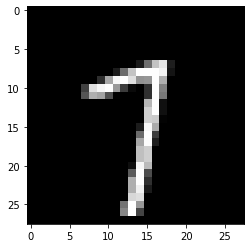

In [ ]:
plt.imshow(train_images[42,:,:], cmap='gray', vmin=0, vmax=1.)
train_labels[42]

In [ ]:
np.shape(test_images)

TensorShape([10000, 28, 28, 1])

4

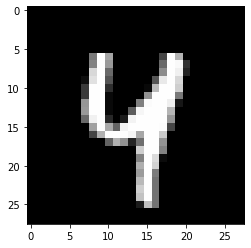

In [ ]:
plt.imshow(test_images[42,:,:], cmap='gray', vmin=0, vmax=1.)
test_labels[42]

Versione corrotta:

In [ ]:
sigma = 0.3
train_corrupt = np.zeros(train_images.shape, dtype=float)


for i in range(x):
    for j in range(y):
        train_corrupt[i,j,:] = train_images[i,j,:] + sigma* np.random.randn()
        

test_corrupt = np.zeros(test_images.shape, dtype=float)
for i in range(a):
    for j in range(b):       
        test_corrupt[i,j,:] = test_images[i,j,:] + sigma* np.random.randn()

Verifichiamo come sono le nuove immagini:

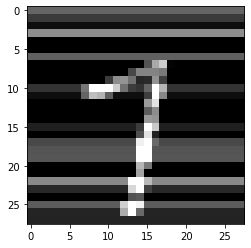

In [ ]:
plt.imshow(train_corrupt[42,:,:], cmap='gray', vmin=0, vmax=1.)

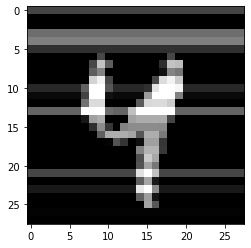

In [ ]:
plt.imshow(test_corrupt[42,:,:], cmap='gray', vmin=0, vmax=1.)

Isolo una percentuale del train da utilizzare come validation per Early stopping:

In [ ]:
train_corrupt, val_corrupt, train_images, val_images = train_test_split(train_corrupt, train_images, test_size=0.1, shuffle=False)

In [ ]:
train_corrupt = tf.reshape(train_corrupt, [-1,28,28,1])
val_corrupt = tf.reshape(val_corrupt, [-1,28,28,1])
test_corrupt = tf.reshape(test_corrupt, [-1,28,28,1])
train_images = tf.reshape(train_images, [-1,28,28,1])
test_images = tf.reshape(test_images, [-1,28,28,1])
val_images = tf.reshape(val_images, [-1,28,28,1])

In [ ]:
X = train_corrupt
Y = train_images

A = val_corrupt
B = val_images

Creo e traino il modello, definisco tutti gli iperparametri:

In [ ]:
model = Sequential()
model.add(InputLayer(input_shape = (y,z,1)))
model.add(Conv2D(4,(7,7), padding = 'same', activation = 'relu', data_format = 'channels_last'))
model.add(Conv2D(8,(3,3), padding = 'same', activation = 'relu', data_format = 'channels_last'))
model.add(Conv2D(1,(7,7), padding = 'same', activation = 'relu', data_format = 'channels_last'))
model.add(Conv2D(4,(5,5), padding = 'same', activation = 'relu', data_format = 'channels_last'))

opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss = tf.keras.losses.MeanSquaredError() ,optimizer = opt, metrics = ['mae'])
callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 3, restore_best_weights= True)

history = model.fit(
    X,
    Y,
    epochs=20,
    callbacks = [callback],
    batch_size=32,
    validation_data=(A,B)
)

Epoch 1/20
1688/1688 [==============================] - 42s 8ms/step - loss: 0.0204 - mae: 0.0598 - val_loss: 0.0034 - val_mae: 0.0206
Epoch 2/20
1688/1688 [==============================] - 12s 7ms/step - loss: 0.0031 - mae: 0.0196 - val_loss: 0.0028 - val_mae: 0.0174
Epoch 3/20
1688/1688 [==============================] - 12s 7ms/step - loss: 0.0023 - mae: 0.0163 - val_loss: 0.0021 - val_mae: 0.0149
Epoch 4/20
1688/1688 [==============================] - 12s 7ms/step - loss: 0.0020 - mae: 0.0147 - val_loss: 0.0018 - val_mae: 0.0135
Epoch 5/20
1688/1688 [==============================] - 12s 7ms/step - loss: 0.0018 - mae: 0.0138 - val_loss: 0.0017 - val_mae: 0.0133
Epoch 6/20
1688/1688 [==============================] - 12s 7ms/step - loss: 0.0017 - mae: 0.0131 - val_loss: 0.0016 - val_mae: 0.0128
Epoch 7/20
1688/1688 [==============================] - 12s 7ms/step - loss: 0.0016 - mae: 0.0126 - val_loss: 0.0015 - val_mae: 0.0120
Epoch 8/20
1688/1688 [==============================] -

Testiamo il modello:

In [ ]:
predictions = model.predict(test_corrupt)

In [ ]:
results =  model.evaluate(test_corrupt,test_images)


313/313 [==============================] - 1s 3ms/step - loss: 4.8615e-04 - mae: 0.0066


Stampiamo una immagine: predetta/corrotta/originale/differenza:

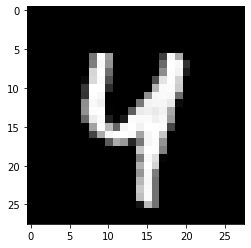

In [ ]:
pred = np.asarray(predictions)
uno = pred[42,:,:,0]
plt.imshow(uno,cmap='gray', vmin=0, vmax=1.)

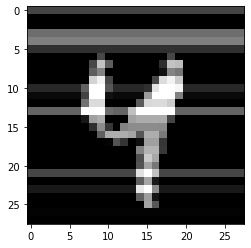

In [ ]:
uno_stripe = test_corrupt[42,:,:,0]
plt.imshow(uno_stripe,cmap='gray', vmin=0, vmax=1.)

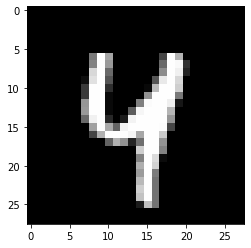

In [ ]:
uno_label = test_images[42,:,:,0]
plt.imshow(uno_label,cmap='gray', vmin=0, vmax=1.)

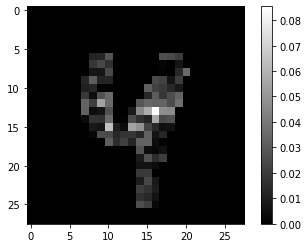

In [ ]:
diff=np.abs(uno_label-uno)
plt.imshow(diff,cmap='gray', vmin=0, vmax=np.max(diff))
plt.colorbar()

In [ ]:
np.max(diff)

0.085398436

Stampiamo il riassunto del modello:

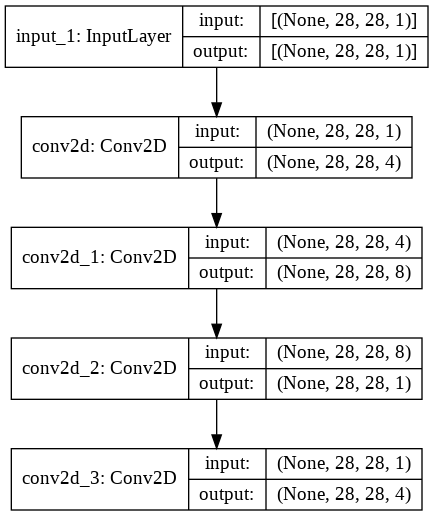

In [ ]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

Stampiamo loss e performance sul train e validation:

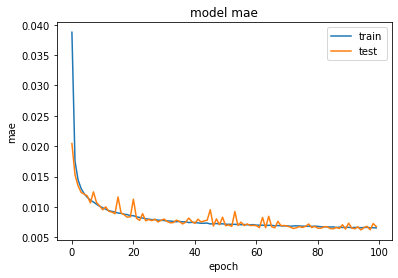

In [ ]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

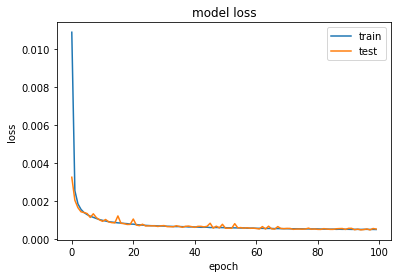

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()